In [1]:
# Use python 3
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from spikelib import spiketools as spkt 
from spikelib.utils import check_directory
from spikelib import visualizations as vis

%matplotlib notebook

In [2]:

exp_name = 'MR-XXXX'
fspikes = '../data/sorting/MR-0092t2.result-1.hdf5'
fanalysis = '../data/processed_protocols/MR-XXXX.hdf5'
fevent = '../data/sync/MR-0092t2/event_list_MR-XXXX.csv'

In [3]:
# Read protocols time directly from fevent file
df = pd.read_csv(fevent)
nd_filter = 'nd2'
intensities = ['50', '100', '150', '200', '255']
intensity = intensities[-2]

# General parameters
samplerate = 20000.0

# Temporal resolution of flash response
psth_bin = 0.01  # In sec
bandwidth_fit = psth_bin
fit_resolution = 0.001  # In sec

# General parameters

In [4]:
# Get time from DataFrame for a especific nd_filter and intensity
flash_name = 'flash_{}_{}'.format(nd_filter, intensity)
fiels_df = ['start_event', 'end_event', 'start_next_event']
bound_time = np.array(
    df[df['protocol_name'] == flash_name][fiels_df])/samplerate

# Stimulius time
(on_dur, off_dur) = np.median(np.diff(bound_time,axis=1), axis=0) # Seconds
offset_time = 0
start_on = offset_time
end_on = offset_time + on_dur
start_off = offset_time + on_dur
end_off = offset_time + off_dur + on_dur
bounds = (start_on, end_on, start_off, end_off)
total_dur = off_dur + on_dur
(start_trials, end_trials) = bound_time[:,[0,2]].T
ntrails = len(start_trials)

bins_fit = np.linspace(start_on, end_off, int(np.ceil(total_dur/fit_resolution)),)
bins_psth = np.linspace(start_on, end_off, int(np.ceil(total_dur/psth_bin)))

In [5]:
# Threshold to select valid unit based on number of trials
resp_thr = 1.0/3 

# Threshold to classify into on, off, onoff
bias_thr = 0.65  

# Threshold for Response Index (RI)
ri_thr = 0.3  
ri_span = 0.1  # Windows time to compute RI in sec


# Paramiters to find the peak response and decay time
fpeak_thr = 0.5  # % of peak response 
fpeak_min_time = 0.01  # min time between peaks in sec
fpeak_min_dist_fit = int(fpeak_min_time/fit_resolution)  # Samples
decrease_factor = np.e 

# Parameters for Sustained Index (SI)
sust_span = 0.4  # Windows time to compute SI in seg

#keywords for spkt.get_features_flash()
kwargs_fit = {'resp_thr': resp_thr,
              'bias_thr': bias_thr,
              'ri_thr': ri_thr,
              'fpeak_thr': fpeak_thr,
              'fpeak_min_dist': fpeak_min_dist_fit,
              'ri_span': ri_span,
              'sust_time': sust_span,
              'decrease_factor': decrease_factor,
             } 

# Load spike times for a unit

In [6]:
key = 'temp_325'
with h5py.File(fspikes, 'r') as spks:  
    spikes = spks['/spiketimes/'+key][...].flatten()/samplerate
trials_flash = spkt.get_trials(spikes, start_trials, end_trials,
                               offset=offset_time)
spks_flash = spkt.flatten_trials(trials_flash)

## plot psth and raster

(<Figure size 576x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f05bb1e4f50>)

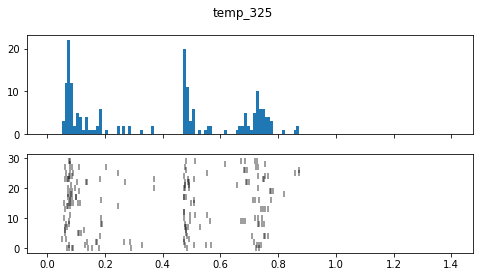

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
fig.suptitle(key)
vis.psth(spks_flash,ax1, bins=int((end_off-start_on)*100), range=(start_on, end_off))
vis.raster(trials_flash,ax2)

# Get flash features
## Using only PSTH to get characteristics of flash response

In [8]:
# Response
(psth, _) = np.histogram(spks_flash, bins=bins_psth)
psth = psth/float(ntrails)

kws_psth = kwargs_fit.copy()
kws_psth['fpeak_min_dist'] = 2

type_psth, char_psth = spkt.get_features_flash(psth, bins_psth[1:], bounds, **kws_psth)

print('Result using PSTH with bin={}'.format(psth_bin))
print('Flash type = {}\nParameters = {}\n'.format(type_psth, char_psth))


Result using PSTH with bin=0.01
Flash type = 3
Parameters = [0.08033143 0.08033857 0.04761905 0.02008286 0.02008286 0.80161943
 0.885      0.81779661 0.78173719 0.73333333 0.66666667]



## Using only fit_response to get characteristics of flash response

In [9]:
# Response
(psth, _) = np.histogram(spks_flash, bins=bins_psth)
psth = psth/float(ntrails)
est_resp = spkt.est_pdf(trials_flash, bins_fit, bandwidth=bandwidth_fit,
                         norm_factor=psth.max())

type_fit, char_fit = spkt.get_features_flash(est_resp, bins_fit, bounds, **kwargs_fit)

print('Result using PDF with bin={}'.format(psth_bin))
print('Flash type = {}\nParameters = {}\n'.format(type_fit, char_fit))

Result using PDF with bin=0.01
Flash type = 3
Parameters = [0.07804441 0.07762274 0.08566272 0.01200683 0.01600911 0.79017717
 0.81061601 0.7984768  0.73670706 0.73333333 0.61760803]



## Plot features from psth and est_psth

In [13]:
def plot_flash(type_fit, char_fit):
    ccolor = {0: 'k', 1: 'r', 2: 'b', 3: 'g'}

    latency_on = char_fit[0]
    latency_off = char_fit[1]
    dacay_on = char_fit[3]
    decay_off = char_fit[4]
    start_on, end_on, start_off, end_off = bounds
    max_amp = est_resp.max()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    fig.suptitle(key)
    ax1.plot(bins_fit, est_resp, c=ccolor[type_fit])
    ax1.step(bins_psth[1:], psth)
    ax1.vlines(start_on+latency_on, 0, max_amp, alpha=0.5)
    ax1.vlines(start_on+latency_on+dacay_on, 0, max_amp, alpha=0.5)
    ax1.vlines(start_off+latency_off, 0, max_amp, alpha=0.5)
    ax1.vlines(start_off+latency_off+decay_off, 0, max_amp, alpha=0.5)
    ax1.set_xlim([start_on, end_off])

    nrep = len(trials_flash)
    for krep, ktrial in enumerate(trials_flash):
        ax2.scatter(ktrial, krep*np.ones_like(ktrial),
                    marker='|', c='k', alpha=0.5)
    ax2.vlines(start_on+latency_on, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_on+latency_on+dacay_on, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_off+latency_off, 0, nrep, alpha=0.5, color='r')
    ax2.vlines(start_off+latency_off+decay_off, 0, nrep, alpha=0.5, color='r')
    ax2.set_xlim([start_on, end_off])
    plt.show()

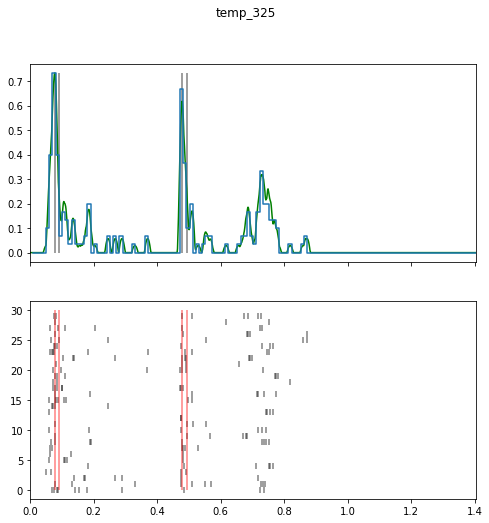

In [14]:
plot_flash(type_fit, char_fit)